In [7]:
import pandas

from datetime import datetime, timedelta
from matplotlib import pyplot

In [8]:
df = pandas.read_csv("scaling_network_bound_3.csv")
df

,measurementID,version,lang,startTime,uuid,newcontainer,vmuptime,platform,containerID,functionName,...,vmcpusteal,contextSwitches,frameworkRuntime,runtime,endTime,network_rx_bytes.vinternal_1,network_rx_bytes.telemetry1_sb,network_rx_bytes.vtarget_1,network_rx_bytes.lo,partitions
0,0,0.5,python,1639225049343,8bbc6f08-5cc9-412d-ba8a-d8fc481929f5,0,1639220411,AWS Lambda,2021/12/11/[$LATEST]f2fd34cae6e24d29b7715c07a7...,root_lambda,...,59,61185,123,123,1639225049466,35030474,176,0,72171,512
1,1,0.5,python,1639225050468,8bbc6f08-5cc9-412d-ba8a-d8fc481929f5,0,1639220411,AWS Lambda,2021/12/11/[$LATEST]f2fd34cae6e24d29b7715c07a7...,root_lambda,...,60,61848,75,76,1639225050544,35032867,176,0,72171,512
2,2,0.5,python,1639225051545,8bbc6f08-5cc9-412d-ba8a-d8fc481929f5,0,1639220411,AWS Lambda,2021/12/11/[$LATEST]f2fd34cae6e24d29b7715c07a7...,root_lambda,...,60,62496,78,78,1639225051623,36829576,176,0,72171,512
3,3,0.5,python,1639225052625,8bbc6f08-5cc9-412d-ba8a-d8fc481929f5,0,1639220411,AWS Lambda,2021/12/11/[$LATEST]f2fd34cae6e24d29b7715c07a7...,root_lambda,...,60,63074,179,179,1639225052804,36829576,176,0,72171,512
4,4,0.5,python,1639225053805,8bbc6f08-5cc9-412d-ba8a-d8fc481929f5,0,1639220411,AWS Lambda,2021/12/11/[$LATEST]f2fd34cae6e24d29b7715c07a7...,root_lambda,...,60,64151,67,67,1639225053872,45123541,176,0,72171,512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42002,658,0.5,python,1639239675614,109e404b-f330-471c-b847-b5aba28010db,0,1639236500,AWS Lambda,2021/12/11/[$LATEST]7b1b0a00211342b5be7d056e45...,root_lambda,...,435,223363,80,80,1639239675694,2189817513,90,0,30864,8
42003,659,0.5,python,1639239676695,109e404b-f330-471c-b847-b5aba28010db,0,1639236500,AWS Lambda,2021/12/11/[$LATEST]7b1b0a00211342b5be7d056e45...,root_lambda,...,436,223605,38,38,1639239676733,2195038649,90,0,30864,8
42004,660,0.5,python,1639239677735,109e404b-f330-471c-b847-b5aba28010db,0,1639236500,AWS Lambda,2021/12/11/[$LATEST]7b1b0a00211342b5be7d056e45...,root_lambda,...,436,224007,78,78,1639239677813,2205495899,90,0,30864,8
42005,661,0.5,python,1639239678815,109e404b-f330-471c-b847-b5aba28010db,0,1639236500,AWS Lambda,2021/12/11/[$LATEST]7b1b0a00211342b5be7d056e45...,root_lambda,...,436,224230,79,79,1639239678894,2205495899,90,0,30864,8


In [9]:
for label, curdf in df.groupby("partitions"):
    print(f"npartitions: {label}, nlambdas: {len(curdf.groupby('uuid'))}")

npartitions: 8, nlambdas: 8
npartitions: 16, nlambdas: 16
npartitions: 32, nlambdas: 32
npartitions: 64, nlambdas: 64
npartitions: 128, nlambdas: 128
npartitions: 256, nlambdas: 256
npartitions: 512, nlambdas: 509


In [56]:
for label, curdf in df.groupby("partitions"):
    if label == 8:
        df_8lambdas = curdf
    if label == 128:
        df_128lambdas = curdf
    runtime = (curdf.endTime.max() - curdf.startTime.min())/1000
    speedup = 1 / (runtime / 777.818)
    print(f"npartitions: {label}, Runtime: {runtime} seconds, speedup: {speedup}")

npartitions: 8, Runtime: 777.818 seconds, speedup: 1.0
npartitions: 16, Runtime: 426.766 seconds, speedup: 1.8225866165533333
npartitions: 32, Runtime: 204.108 seconds, speedup: 3.810815842593137
npartitions: 64, Runtime: 113.97 seconds, speedup: 6.824760901991752
npartitions: 128, Runtime: 80.956 seconds, speedup: 9.607910469884875
npartitions: 256, Runtime: 87.439 seconds, speedup: 8.895550040599732
npartitions: 512, Runtime: 53.661 seconds, speedup: 14.495033637092115


In [11]:
start_timestamp = df_8lambdas["startTime"].min() / 1000
end_timestamp = df_8lambdas["endTime"].max() / 1000
start_datetime = datetime.fromtimestamp(start_timestamp)
end_datetime = datetime.fromtimestamp(end_timestamp)

print(start_datetime)
print(end_datetime)
print(f"Total runtime: {round(end_timestamp - start_timestamp, 2)} seconds")

2021-12-11 17:09:34.636000
2021-12-11 17:22:32.454000
Total runtime: 777.82 seconds


Text(0, 0.5, 'Lambda invokation')

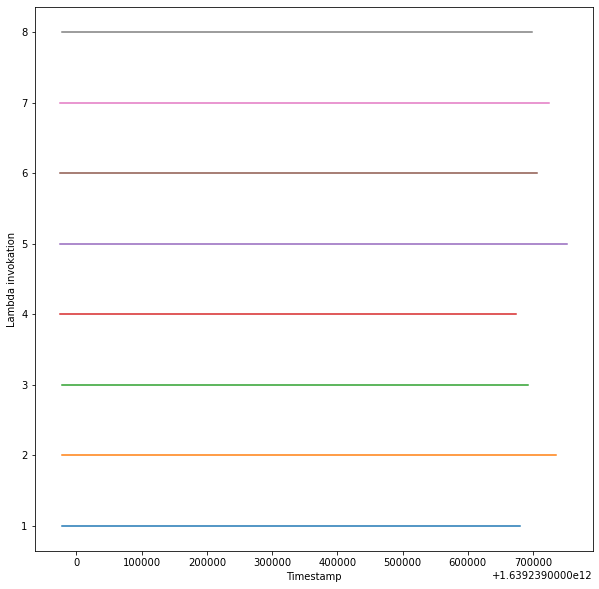

In [12]:
pyplot.figure(figsize=(10,10))
for number, (label, lambdadf) in enumerate(df_8lambdas.groupby("uuid")):
    pyplot.plot(lambdadf.groupby("startTime")["measurementID"].count()+ number)
pyplot.xlabel("Timestamp")
pyplot.ylabel("Lambda invokation")

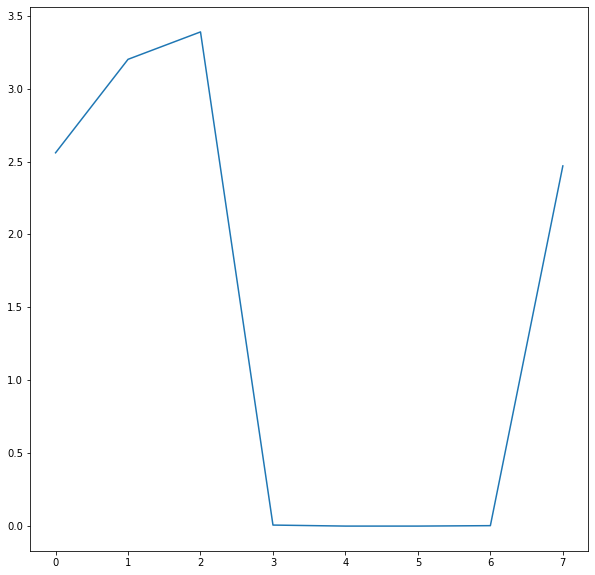

In [13]:
minstartdf = df_8lambdas.groupby('uuid')[["startTime"]].min().reset_index()
minstartdf["startTime"] = minstartdf["startTime"] / 1000

pyplot.figure(figsize=(10,10))
pyplot.plot(minstartdf.index, minstartdf["startTime"]-minstartdf["startTime"].min())

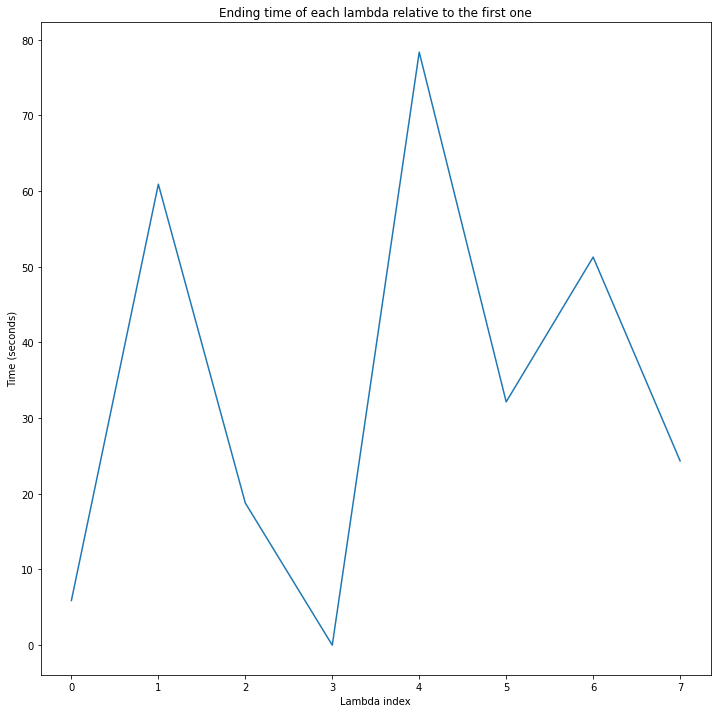

In [14]:
maxenddf = df_8lambdas.groupby('uuid')[["endTime"]].max().reset_index()
maxenddf["endTime"] = maxenddf["endTime"] / 1000

pyplot.figure(figsize=(12,12))
pyplot.title("Ending time of each lambda relative to the first one")
pyplot.xlabel("Lambda index")
pyplot.ylabel("Time (seconds)")
pyplot.plot(maxenddf.index, maxenddf["endTime"]-maxenddf["endTime"].min())

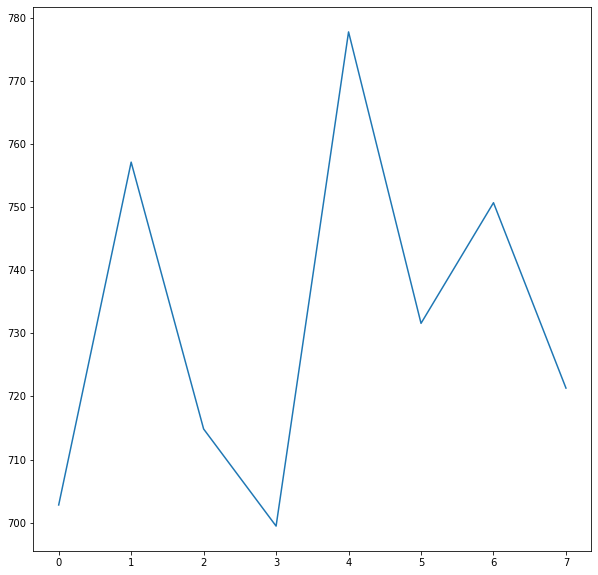

In [15]:
runtimedf = df_8lambdas.groupby('uuid')[["startTime","endTime"]].agg(minstart=("startTime","min"),maxend=("endTime","max")).reset_index()
runtimedf["runtime"] = (runtimedf["maxend"] - runtimedf["minstart"]) / 1000
runtimedf

pyplot.figure(figsize=(10,10))
pyplot.plot(runtimedf.index, runtimedf["runtime"])

In [16]:
cpudf = df_8lambdas[["uuid","startTime","endTime","cpuUsr"]]
cpudf

,uuid,startTime,endTime,cpuUsr
36664,46696ad1-6ee4-4b83-89ad-79661cf23987,1639238974643,1639238974851,27450
36665,46696ad1-6ee4-4b83-89ad-79661cf23987,1639238975853,1639238975949,27509
36666,46696ad1-6ee4-4b83-89ad-79661cf23987,1639238976951,1639238977042,27511
36667,46696ad1-6ee4-4b83-89ad-79661cf23987,1639238978044,1639238978237,27555
36668,46696ad1-6ee4-4b83-89ad-79661cf23987,1639238979239,1639238979335,27625
...,...,...,...,...
42002,109e404b-f330-471c-b847-b5aba28010db,1639239675614,1639239675694,27804
42003,109e404b-f330-471c-b847-b5aba28010db,1639239676695,1639239676733,27826
42004,109e404b-f330-471c-b847-b5aba28010db,1639239677735,1639239677813,27881
42005,109e404b-f330-471c-b847-b5aba28010db,1639239678815,1639239678894,27978


In [17]:
dfs = []
for label, curdf in cpudf.groupby('uuid'):
    curdf["cpuPercent"] = curdf.cpuUsr.diff().shift(-1)
    dfs.append(curdf)


cpupercentdf = pandas.concat(dfs).reset_index(drop=True)
cpupercentdf["startDateTime"] = (cpupercentdf["startTime"]/pow(10,3)).apply(datetime.fromtimestamp)
cpupercentdf

,uuid,startTime,endTime,cpuUsr,cpuPercent,startDateTime
0,109e404b-f330-471c-b847-b5aba28010db,1639238977196,1639238977284,127,86.0,2021-12-11 17:09:37.196
1,109e404b-f330-471c-b847-b5aba28010db,1639238978286,1639238978382,213,22.0,2021-12-11 17:09:38.286
2,109e404b-f330-471c-b847-b5aba28010db,1639238979383,1639238979426,235,2.0,2021-12-11 17:09:39.383
3,109e404b-f330-471c-b847-b5aba28010db,1639238980427,1639238980466,237,4.0,2021-12-11 17:09:40.427
4,109e404b-f330-471c-b847-b5aba28010db,1639238981468,1639238981508,241,50.0,2021-12-11 17:09:41.468
...,...,...,...,...,...,...
5338,f6ea3902-beb4-4995-878b-db275289368a,1639239694044,1639239694132,28132,98.0,2021-12-11 17:21:34.044
5339,f6ea3902-beb4-4995-878b-db275289368a,1639239695134,1639239695216,28230,99.0,2021-12-11 17:21:35.134
5340,f6ea3902-beb4-4995-878b-db275289368a,1639239696218,1639239696314,28329,38.0,2021-12-11 17:21:36.218
5341,f6ea3902-beb4-4995-878b-db275289368a,1639239697316,1639239697352,28367,22.0,2021-12-11 17:21:37.316


In [18]:
networkdf = df_8lambdas[["uuid","startTime","endTime","network_rx_bytes.vinternal_1"]]
dfs = []
for label, curdf in networkdf.groupby('uuid'):
    curdf["networkpersecond"] = curdf["network_rx_bytes.vinternal_1"].diff().shift(-1)
    dfs.append(curdf)


networkperseconddf = pandas.concat(dfs).reset_index(drop=True)
networkperseconddf["startDateTime"] = (networkperseconddf["startTime"]/pow(10,3)).apply(datetime.fromtimestamp)
networkperseconddf

,uuid,startTime,endTime,network_rx_bytes.vinternal_1,networkpersecond,startDateTime
0,109e404b-f330-471c-b847-b5aba28010db,1639238977196,1639238977284,282,0.0,2021-12-11 17:09:37.196
1,109e404b-f330-471c-b847-b5aba28010db,1639238978286,1639238978382,282,986.0,2021-12-11 17:09:38.286
2,109e404b-f330-471c-b847-b5aba28010db,1639238979383,1639238979426,1268,1990.0,2021-12-11 17:09:39.383
3,109e404b-f330-471c-b847-b5aba28010db,1639238980427,1639238980466,3258,109464.0,2021-12-11 17:09:40.427
4,109e404b-f330-471c-b847-b5aba28010db,1639238981468,1639238981508,112722,1399313.0,2021-12-11 17:09:41.468
...,...,...,...,...,...,...
5338,f6ea3902-beb4-4995-878b-db275289368a,1639239694044,1639239694132,2243127660,0.0,2021-12-11 17:21:34.044
5339,f6ea3902-beb4-4995-878b-db275289368a,1639239695134,1639239695216,2243127660,0.0,2021-12-11 17:21:35.134
5340,f6ea3902-beb4-4995-878b-db275289368a,1639239696218,1639239696314,2243127660,1271210.0,2021-12-11 17:21:36.218
5341,f6ea3902-beb4-4995-878b-db275289368a,1639239697316,1639239697352,2244398870,19204434.0,2021-12-11 17:21:37.316


In [19]:
metrics = df_8lambdas[["uuid","startTime","cpuUsr","network_rx_bytes.vinternal_1"]].copy()
metrics

,uuid,startTime,cpuUsr,network_rx_bytes.vinternal_1
36664,46696ad1-6ee4-4b83-89ad-79661cf23987,1639238974643,27450,2167065351
36665,46696ad1-6ee4-4b83-89ad-79661cf23987,1639238975853,27509,2167066790
36666,46696ad1-6ee4-4b83-89ad-79661cf23987,1639238976951,27511,2167088314
36667,46696ad1-6ee4-4b83-89ad-79661cf23987,1639238978044,27555,2168862275
36668,46696ad1-6ee4-4b83-89ad-79661cf23987,1639238979239,27625,2168862341
...,...,...,...,...
42002,109e404b-f330-471c-b847-b5aba28010db,1639239675614,27804,2189817513
42003,109e404b-f330-471c-b847-b5aba28010db,1639239676695,27826,2195038649
42004,109e404b-f330-471c-b847-b5aba28010db,1639239677735,27881,2205495899
42005,109e404b-f330-471c-b847-b5aba28010db,1639239678815,27978,2205495899


In [20]:
metrics["startDateTime"] = (metrics["startTime"]/pow(10,3)).apply(datetime.fromtimestamp)
metrics

,uuid,startTime,cpuUsr,network_rx_bytes.vinternal_1,startDateTime
36664,46696ad1-6ee4-4b83-89ad-79661cf23987,1639238974643,27450,2167065351,2021-12-11 17:09:34.643
36665,46696ad1-6ee4-4b83-89ad-79661cf23987,1639238975853,27509,2167066790,2021-12-11 17:09:35.853
36666,46696ad1-6ee4-4b83-89ad-79661cf23987,1639238976951,27511,2167088314,2021-12-11 17:09:36.951
36667,46696ad1-6ee4-4b83-89ad-79661cf23987,1639238978044,27555,2168862275,2021-12-11 17:09:38.044
36668,46696ad1-6ee4-4b83-89ad-79661cf23987,1639238979239,27625,2168862341,2021-12-11 17:09:39.239
...,...,...,...,...,...
42002,109e404b-f330-471c-b847-b5aba28010db,1639239675614,27804,2189817513,2021-12-11 17:21:15.614
42003,109e404b-f330-471c-b847-b5aba28010db,1639239676695,27826,2195038649,2021-12-11 17:21:16.695
42004,109e404b-f330-471c-b847-b5aba28010db,1639239677735,27881,2205495899,2021-12-11 17:21:17.735
42005,109e404b-f330-471c-b847-b5aba28010db,1639239678815,27978,2205495899,2021-12-11 17:21:18.815


In [21]:
def round_seconds(obj: datetime, how="previous") -> datetime:
    if how=="previous":
        obj -= timedelta(seconds=1)
    else:
        obj += timedelta(seconds=1)
    return obj.replace(microsecond=0)

timebins = []
current_datetime = round_seconds(start_datetime)
while current_datetime <= end_datetime:
    timebins.append(current_datetime)
    current_datetime += timedelta(seconds=2)
timebins.append(round_seconds(end_datetime, how="next"))
timebins

[datetime.datetime(2021, 12, 11, 17, 9, 33),
 datetime.datetime(2021, 12, 11, 17, 9, 35),
 datetime.datetime(2021, 12, 11, 17, 9, 37),
 datetime.datetime(2021, 12, 11, 17, 9, 39),
 datetime.datetime(2021, 12, 11, 17, 9, 41),
 datetime.datetime(2021, 12, 11, 17, 9, 43),
 datetime.datetime(2021, 12, 11, 17, 9, 45),
 datetime.datetime(2021, 12, 11, 17, 9, 47),
 datetime.datetime(2021, 12, 11, 17, 9, 49),
 datetime.datetime(2021, 12, 11, 17, 9, 51),
 datetime.datetime(2021, 12, 11, 17, 9, 53),
 datetime.datetime(2021, 12, 11, 17, 9, 55),
 datetime.datetime(2021, 12, 11, 17, 9, 57),
 datetime.datetime(2021, 12, 11, 17, 9, 59),
 datetime.datetime(2021, 12, 11, 17, 10, 1),
 datetime.datetime(2021, 12, 11, 17, 10, 3),
 datetime.datetime(2021, 12, 11, 17, 10, 5),
 datetime.datetime(2021, 12, 11, 17, 10, 7),
 datetime.datetime(2021, 12, 11, 17, 10, 9),
 datetime.datetime(2021, 12, 11, 17, 10, 11),
 datetime.datetime(2021, 12, 11, 17, 10, 13),
 datetime.datetime(2021, 12, 11, 17, 10, 15),
 dateti

In [22]:
metrics["bins"] = pandas.cut(metrics["startDateTime"], timebins)
metrics

,uuid,startTime,cpuUsr,network_rx_bytes.vinternal_1,startDateTime,bins
36664,46696ad1-6ee4-4b83-89ad-79661cf23987,1639238974643,27450,2167065351,2021-12-11 17:09:34.643,"(2021-12-11 17:09:33, 2021-12-11 17:09:35]"
36665,46696ad1-6ee4-4b83-89ad-79661cf23987,1639238975853,27509,2167066790,2021-12-11 17:09:35.853,"(2021-12-11 17:09:35, 2021-12-11 17:09:37]"
36666,46696ad1-6ee4-4b83-89ad-79661cf23987,1639238976951,27511,2167088314,2021-12-11 17:09:36.951,"(2021-12-11 17:09:35, 2021-12-11 17:09:37]"
36667,46696ad1-6ee4-4b83-89ad-79661cf23987,1639238978044,27555,2168862275,2021-12-11 17:09:38.044,"(2021-12-11 17:09:37, 2021-12-11 17:09:39]"
36668,46696ad1-6ee4-4b83-89ad-79661cf23987,1639238979239,27625,2168862341,2021-12-11 17:09:39.239,"(2021-12-11 17:09:39, 2021-12-11 17:09:41]"
...,...,...,...,...,...,...
42002,109e404b-f330-471c-b847-b5aba28010db,1639239675614,27804,2189817513,2021-12-11 17:21:15.614,"(2021-12-11 17:21:15, 2021-12-11 17:21:17]"
42003,109e404b-f330-471c-b847-b5aba28010db,1639239676695,27826,2195038649,2021-12-11 17:21:16.695,"(2021-12-11 17:21:15, 2021-12-11 17:21:17]"
42004,109e404b-f330-471c-b847-b5aba28010db,1639239677735,27881,2205495899,2021-12-11 17:21:17.735,"(2021-12-11 17:21:17, 2021-12-11 17:21:19]"
42005,109e404b-f330-471c-b847-b5aba28010db,1639239678815,27978,2205495899,2021-12-11 17:21:18.815,"(2021-12-11 17:21:17, 2021-12-11 17:21:19]"


Text(0, 0.5, 'Lambda invokation')

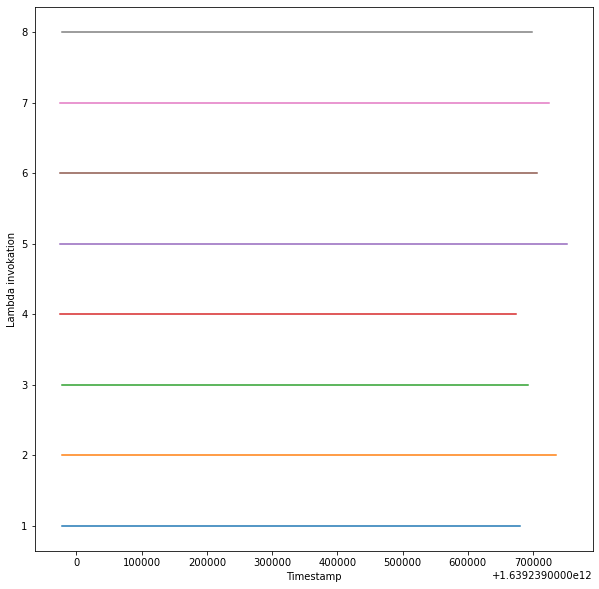

In [23]:
pyplot.figure(figsize=(10,10))
for number, (label, lambdadf) in enumerate(metrics.groupby("uuid")):
    pyplot.plot(lambdadf.groupby("startTime")["cpuUsr"].count() + number)
pyplot.xlabel("Timestamp")
pyplot.ylabel("Lambda invokation")

In [24]:
for grouplabel, groupdf in metrics.groupby(["bins"]):
    #print(f"Label: {grouplabel}")
    print(f"Entries: {len(groupdf)}")
    #print(f"DataFrame: {groupdf}")
    print(len(groupdf.uuid.unique()))

Entries: 4
4
Entries: 8
4
Entries: 11
8
Entries: 15
8
Entries: 16
8
Entries: 16
8
Entries: 12
8
Entries: 15
8
Entries: 14
8
Entries: 14
8
Entries: 14
8
Entries: 16
8
Entries: 14
8
Entries: 16
8
Entries: 14
8
Entries: 15
8
Entries: 14
8
Entries: 14
8
Entries: 15
8
Entries: 14
8
Entries: 15
8
Entries: 16
8
Entries: 15
8
Entries: 11
8
Entries: 16
8
Entries: 16
8
Entries: 15
8
Entries: 13
8
Entries: 15
8
Entries: 14
8
Entries: 16
8
Entries: 15
8
Entries: 13
8
Entries: 15
8
Entries: 15
8
Entries: 16
8
Entries: 14
8
Entries: 13
8
Entries: 15
8
Entries: 15
8
Entries: 14
8
Entries: 14
8
Entries: 15
8
Entries: 15
8
Entries: 15
8
Entries: 14
8
Entries: 14
8
Entries: 15
8
Entries: 14
8
Entries: 15
8
Entries: 15
8
Entries: 14
8
Entries: 16
8
Entries: 14
8
Entries: 14
8
Entries: 15
8
Entries: 15
8
Entries: 14
8
Entries: 14
8
Entries: 15
8
Entries: 16
8
Entries: 14
8
Entries: 13
8
Entries: 15
8
Entries: 15
8
Entries: 14
8
Entries: 14
8
Entries: 16
8
Entries: 15
8
Entries: 15
8
Entries: 12
8
Entries:

In [25]:
cpupercentdf["bins"] = pandas.cut(cpupercentdf["startDateTime"], timebins)
cpupercentdf

,uuid,startTime,endTime,cpuUsr,cpuPercent,startDateTime,bins
0,109e404b-f330-471c-b847-b5aba28010db,1639238977196,1639238977284,127,86.0,2021-12-11 17:09:37.196,"(2021-12-11 17:09:37, 2021-12-11 17:09:39]"
1,109e404b-f330-471c-b847-b5aba28010db,1639238978286,1639238978382,213,22.0,2021-12-11 17:09:38.286,"(2021-12-11 17:09:37, 2021-12-11 17:09:39]"
2,109e404b-f330-471c-b847-b5aba28010db,1639238979383,1639238979426,235,2.0,2021-12-11 17:09:39.383,"(2021-12-11 17:09:39, 2021-12-11 17:09:41]"
3,109e404b-f330-471c-b847-b5aba28010db,1639238980427,1639238980466,237,4.0,2021-12-11 17:09:40.427,"(2021-12-11 17:09:39, 2021-12-11 17:09:41]"
4,109e404b-f330-471c-b847-b5aba28010db,1639238981468,1639238981508,241,50.0,2021-12-11 17:09:41.468,"(2021-12-11 17:09:41, 2021-12-11 17:09:43]"
...,...,...,...,...,...,...,...
5338,f6ea3902-beb4-4995-878b-db275289368a,1639239694044,1639239694132,28132,98.0,2021-12-11 17:21:34.044,"(2021-12-11 17:21:33, 2021-12-11 17:21:35]"
5339,f6ea3902-beb4-4995-878b-db275289368a,1639239695134,1639239695216,28230,99.0,2021-12-11 17:21:35.134,"(2021-12-11 17:21:35, 2021-12-11 17:21:37]"
5340,f6ea3902-beb4-4995-878b-db275289368a,1639239696218,1639239696314,28329,38.0,2021-12-11 17:21:36.218,"(2021-12-11 17:21:35, 2021-12-11 17:21:37]"
5341,f6ea3902-beb4-4995-878b-db275289368a,1639239697316,1639239697352,28367,22.0,2021-12-11 17:21:37.316,"(2021-12-11 17:21:37, 2021-12-11 17:21:39]"


In [26]:
networkperseconddf["bins"] = pandas.cut(networkperseconddf["startDateTime"], timebins)
networkperseconddf

,uuid,startTime,endTime,network_rx_bytes.vinternal_1,networkpersecond,startDateTime,bins
0,109e404b-f330-471c-b847-b5aba28010db,1639238977196,1639238977284,282,0.0,2021-12-11 17:09:37.196,"(2021-12-11 17:09:37, 2021-12-11 17:09:39]"
1,109e404b-f330-471c-b847-b5aba28010db,1639238978286,1639238978382,282,986.0,2021-12-11 17:09:38.286,"(2021-12-11 17:09:37, 2021-12-11 17:09:39]"
2,109e404b-f330-471c-b847-b5aba28010db,1639238979383,1639238979426,1268,1990.0,2021-12-11 17:09:39.383,"(2021-12-11 17:09:39, 2021-12-11 17:09:41]"
3,109e404b-f330-471c-b847-b5aba28010db,1639238980427,1639238980466,3258,109464.0,2021-12-11 17:09:40.427,"(2021-12-11 17:09:39, 2021-12-11 17:09:41]"
4,109e404b-f330-471c-b847-b5aba28010db,1639238981468,1639238981508,112722,1399313.0,2021-12-11 17:09:41.468,"(2021-12-11 17:09:41, 2021-12-11 17:09:43]"
...,...,...,...,...,...,...,...
5338,f6ea3902-beb4-4995-878b-db275289368a,1639239694044,1639239694132,2243127660,0.0,2021-12-11 17:21:34.044,"(2021-12-11 17:21:33, 2021-12-11 17:21:35]"
5339,f6ea3902-beb4-4995-878b-db275289368a,1639239695134,1639239695216,2243127660,0.0,2021-12-11 17:21:35.134,"(2021-12-11 17:21:35, 2021-12-11 17:21:37]"
5340,f6ea3902-beb4-4995-878b-db275289368a,1639239696218,1639239696314,2243127660,1271210.0,2021-12-11 17:21:36.218,"(2021-12-11 17:21:35, 2021-12-11 17:21:37]"
5341,f6ea3902-beb4-4995-878b-db275289368a,1639239697316,1639239697352,2244398870,19204434.0,2021-12-11 17:21:37.316,"(2021-12-11 17:21:37, 2021-12-11 17:21:39]"


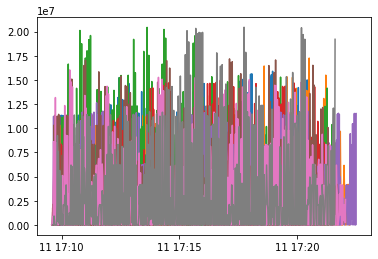

In [27]:
for label, curdf in networkperseconddf.groupby("uuid"):
    pyplot.plot(curdf["startDateTime"], curdf["networkpersecond"])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fced0c3fd60>,
 'caps': [<matplotlib.lines.Line2D at 0x7fced0c3c3d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fced0c3f6d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fced0c3dea0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fced0c3fe50>],
 'means': []}

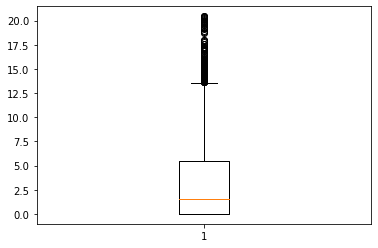

In [28]:
pyplot.boxplot(networkperseconddf["networkpersecond"].dropna()/pow(10,6))

In [29]:
for grouplabel, groupdf in cpupercentdf.groupby(["bins"]):
    #print(f"Label: {grouplabel}")
    print(f"Entries: {len(groupdf)}")
    #print(f"DataFrame: {groupdf}")
    print(len(groupdf.uuid.unique()))

Entries: 4
4
Entries: 8
4
Entries: 11
8
Entries: 15
8
Entries: 16
8
Entries: 16
8
Entries: 12
8
Entries: 15
8
Entries: 14
8
Entries: 14
8
Entries: 14
8
Entries: 16
8
Entries: 14
8
Entries: 16
8
Entries: 14
8
Entries: 15
8
Entries: 14
8
Entries: 14
8
Entries: 15
8
Entries: 14
8
Entries: 15
8
Entries: 16
8
Entries: 15
8
Entries: 11
8
Entries: 16
8
Entries: 16
8
Entries: 15
8
Entries: 13
8
Entries: 15
8
Entries: 14
8
Entries: 16
8
Entries: 15
8
Entries: 13
8
Entries: 15
8
Entries: 15
8
Entries: 16
8
Entries: 14
8
Entries: 13
8
Entries: 15
8
Entries: 15
8
Entries: 14
8
Entries: 14
8
Entries: 15
8
Entries: 15
8
Entries: 15
8
Entries: 14
8
Entries: 14
8
Entries: 15
8
Entries: 14
8
Entries: 15
8
Entries: 15
8
Entries: 14
8
Entries: 16
8
Entries: 14
8
Entries: 14
8
Entries: 15
8
Entries: 15
8
Entries: 14
8
Entries: 14
8
Entries: 15
8
Entries: 16
8
Entries: 14
8
Entries: 13
8
Entries: 15
8
Entries: 15
8
Entries: 14
8
Entries: 14
8
Entries: 16
8
Entries: 15
8
Entries: 15
8
Entries: 12
8
Entries:

In [30]:
def f(series):
    return len(series.unique())
cpusumdf = metrics.groupby("bins").agg(cpu_sum=("cpuUsr","sum"), numlambdas=("uuid",f)).reset_index()
cpusumdf

,bins,cpu_sum,numlambdas
0,"(2021-12-11 17:09:33, 2021-12-11 17:09:35]",113246,4
1,"(2021-12-11 17:09:35, 2021-12-11 17:09:37]",226970,4
2,"(2021-12-11 17:09:37, 2021-12-11 17:09:39]",114830,8
3,"(2021-12-11 17:09:39, 2021-12-11 17:09:41]",229469,8
4,"(2021-12-11 17:09:41, 2021-12-11 17:09:43]",230896,8
...,...,...,...
385,"(2021-12-11 17:22:23, 2021-12-11 17:22:25]",107466,1
386,"(2021-12-11 17:22:25, 2021-12-11 17:22:27]",107593,1
387,"(2021-12-11 17:22:27, 2021-12-11 17:22:29]",107747,1
388,"(2021-12-11 17:22:29, 2021-12-11 17:22:31]",53951,1


In [51]:
cpusumdfpercent = cpupercentdf.groupby("bins").agg(cpu_sum=("cpuPercent","sum"), numlambdas=("uuid",f)).reset_index()
cpusumdfpercent["timelabels"] = cpusumdfpercent["bins"].apply(lambda x: x.left)
init_time = cpusumdfpercent["timelabels"][0]
cpusumdfpercent["timelabels"] = cpusumdfpercent["timelabels"].apply(lambda x: (x - init_time).seconds)
cpusumdfpercent

,bins,cpu_sum,numlambdas,timelabels
0,"(2021-12-11 17:09:33, 2021-12-11 17:09:35]",236.0,4,0
1,"(2021-12-11 17:09:35, 2021-12-11 17:09:37]",150.0,4,2
2,"(2021-12-11 17:09:37, 2021-12-11 17:09:39]",592.0,8,4
3,"(2021-12-11 17:09:39, 2021-12-11 17:09:41]",410.0,8,6
4,"(2021-12-11 17:09:41, 2021-12-11 17:09:43]",1014.0,8,8
...,...,...,...,...
385,"(2021-12-11 17:22:23, 2021-12-11 17:22:25]",103.0,1,770
386,"(2021-12-11 17:22:25, 2021-12-11 17:22:27]",37.0,1,772
387,"(2021-12-11 17:22:27, 2021-12-11 17:22:29]",129.0,1,774
388,"(2021-12-11 17:22:29, 2021-12-11 17:22:31]",105.0,1,776


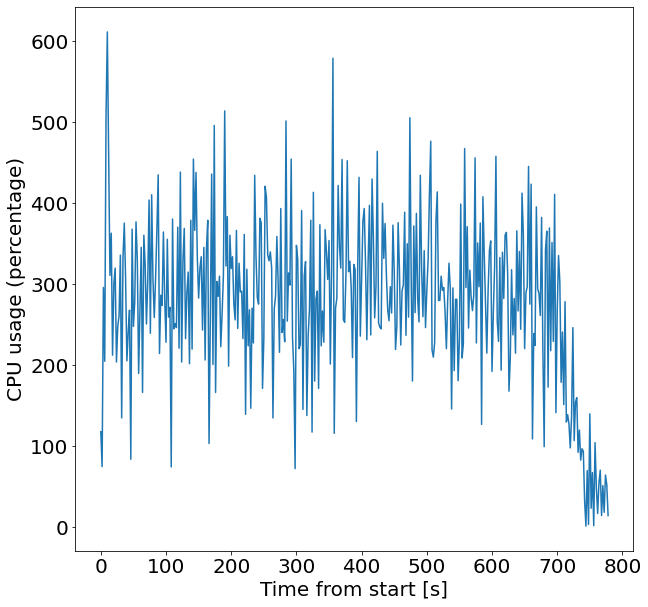

In [55]:
fig, ax = pyplot.subplots(figsize=(10,10))
pyplot.plot(cpusumdfpercent["timelabels"], cpusumdfpercent["cpu_sum"]/2, label="CPU Usage")
pyplot.xlabel("Time from start [s]", size=20)
pyplot.ylabel("CPU usage (percentage)", size=20)
pyplot.tick_params(labelsize=20)

fig.savefig('cpuusage_pps.png',
            format='png',
            dpi=400,
            bbox_inches='tight')

In [33]:
cpusumdfpercent["bins"].apply(lambda x: x.left)

0     2021-12-11 17:09:33
1     2021-12-11 17:09:35
2     2021-12-11 17:09:37
3     2021-12-11 17:09:39
4     2021-12-11 17:09:41
              ...        
385   2021-12-11 17:22:23
386   2021-12-11 17:22:25
387   2021-12-11 17:22:27
388   2021-12-11 17:22:29
389   2021-12-11 17:22:31
Name: bins, Length: 390, dtype: category
Categories (390, datetime64[ns]): [2021-12-11 17:09:33 < 2021-12-11 17:09:35 < 2021-12-11 17:09:37 < 2021-12-11 17:09:39 ... 2021-12-11 17:22:25 < 2021-12-11 17:22:27 < 2021-12-11 17:22:29 < 2021-12-11 17:22:31]

In [34]:
networksumdf = metrics.groupby("bins").agg(network_sum=("network_rx_bytes.vinternal_1","sum"), numlambdas=("uuid",f)).reset_index()
networksumdf

,bins,network_sum,numlambdas
0,"(2021-12-11 17:09:33, 2021-12-11 17:09:35]",8942038285,4
1,"(2021-12-11 17:09:35, 2021-12-11 17:09:37]",17884240500,4
2,"(2021-12-11 17:09:37, 2021-12-11 17:09:39]",8946147465,8
3,"(2021-12-11 17:09:39, 2021-12-11 17:09:41]",17923125963,8
4,"(2021-12-11 17:09:41, 2021-12-11 17:09:43]",18013770467,8
...,...,...,...
385,"(2021-12-11 17:22:23, 2021-12-11 17:22:25]",8765411252,1
386,"(2021-12-11 17:22:25, 2021-12-11 17:22:27]",8766947541,1
387,"(2021-12-11 17:22:27, 2021-12-11 17:22:29]",8791449226,1
388,"(2021-12-11 17:22:29, 2021-12-11 17:22:31]",4407214608,1


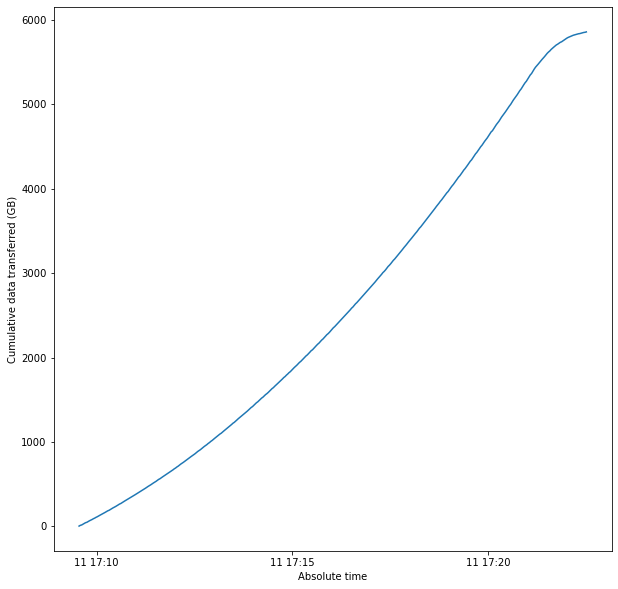

In [35]:
networkcumsumdf = metrics[["bins","network_rx_bytes.vinternal_1"]].groupby("bins").sum().cumsum().reset_index()
fig, ax = pyplot.subplots(figsize=(10,10))
pyplot.plot(networkcumsumdf["bins"].apply(lambda x: x.left), networkcumsumdf["network_rx_bytes.vinternal_1"]/pow(10,9)/2, label="Data Transferred")
pyplot.xlabel("Absolute time")
pyplot.ylabel("Cumulative data transferred (GB)")
fig.savefig('network_sum_pps.png',
            format='png',
            dpi=300,
            bbox_inches='tight')

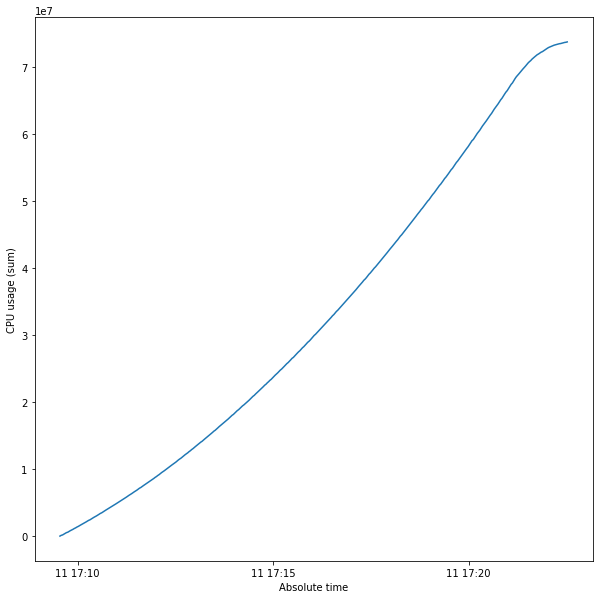

In [36]:
cpucumsumdf = cpusumdf[["bins","cpu_sum"]].groupby("bins").sum().cumsum().reset_index()

fig, ax = pyplot.subplots(figsize=(10,10))
pyplot.plot(cpucumsumdf["bins"].apply(lambda x: x.left), cpucumsumdf["cpu_sum"]/2, label="CPU Usage")
pyplot.xlabel("Absolute time")
pyplot.ylabel("CPU usage (sum)")
fig.savefig('cpuusage_sum.png',
            format='png',
            dpi=300,
            bbox_inches='tight')

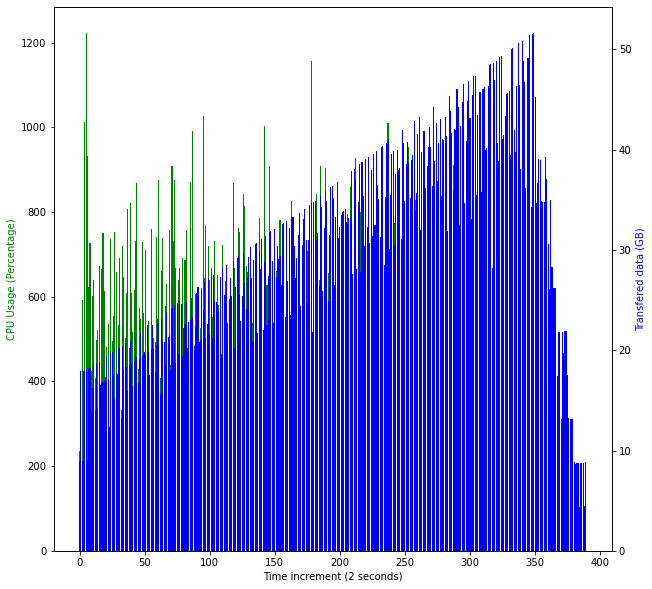

In [37]:
fig,ax = pyplot.subplots(figsize=(10,10))
ax.bar(cpusumdfpercent.index, cpusumdfpercent["cpu_sum"], color="green")
ax.set_ylabel("CPU Usage (Percentage)", color="green")
ax2 = ax.twinx()
ax2.bar(networksumdf.index, networksumdf["network_sum"]/pow(10,9), color="blue")
ax2.set_ylabel("Transfered data (GB)", color="blue")
ax.set_xlabel("Time increment (2 seconds)")
fig.savefig('cpuandnetwork.png',
            format='png',
            dpi=300,
            bbox_inches='tight')

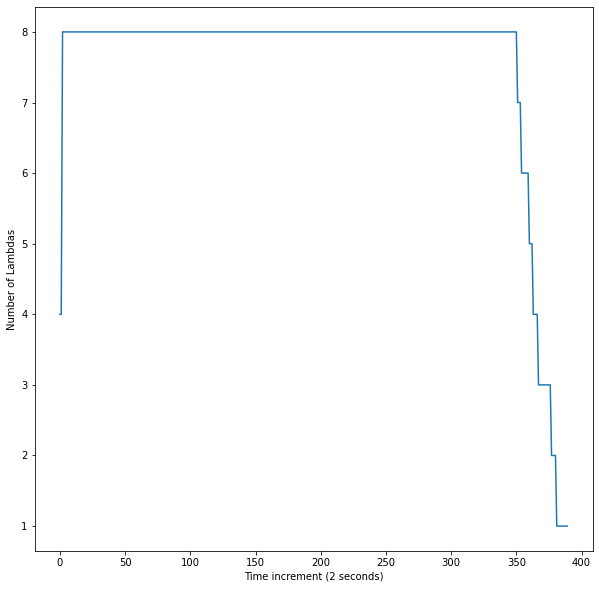

In [38]:
fig,ax = pyplot.subplots(figsize=(10,10))
ax.plot(cpusumdf["numlambdas"])
#pyplot.yticks(list(range(0,70,5)))
pyplot.xlabel("Time increment (2 seconds)")
pyplot.ylabel("Number of Lambdas")
fig.savefig('numlambdas.png',
            format='png',
            dpi=300,
            bbox_inches='tight')

Text(0, 0.5, 'CPU Usage (Percentage)')

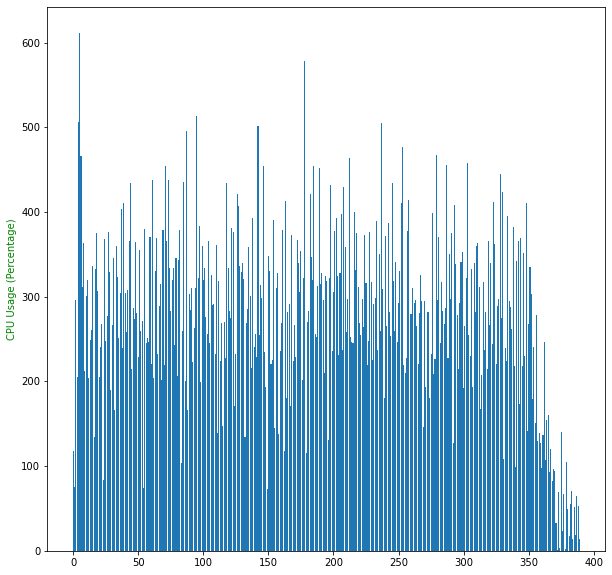

In [39]:
fig,ax = pyplot.subplots(figsize=(10,10))
ax.bar(cpusumdfpercent.index, cpusumdfpercent["cpu_sum"]/2)
ax.set_ylabel("CPU Usage (Percentage)", color="green")


# 128 Lambda
Chosen because 128 is the highest number that still shows nice behaviour

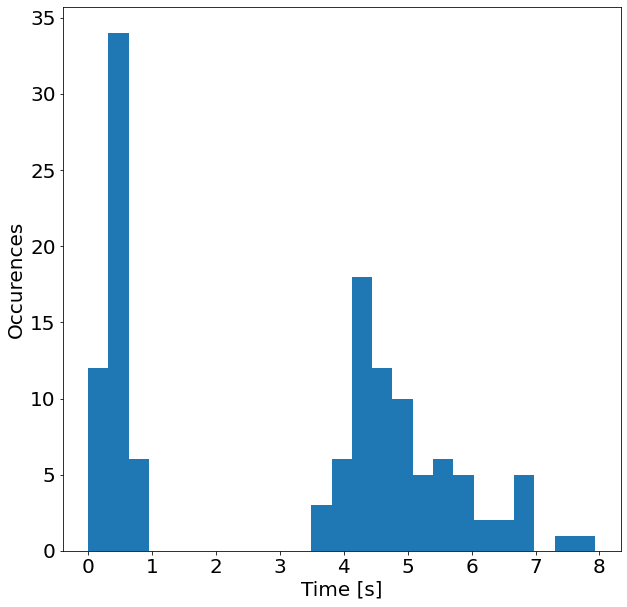

In [58]:
minstartdf = df_128lambdas.groupby('uuid')[["startTime"]].min().reset_index()
minstartdf["startTime"] = minstartdf["startTime"] / 1000

fig, ax = pyplot.subplots(figsize=(10,10))
#pyplot.title("Starting time of each lambda relative to the first one", size=20)
pyplot.xlabel("Time [s]", size=20)
pyplot.ylabel("Occurences", size=20)
pyplot.tick_params(labelsize=20)

pyplot.hist(minstartdf["startTime"]-minstartdf["startTime"].min(), bins=25)

fig.savefig('relativestart_pps.png',
            format='png',
            dpi=400,
            bbox_inches='tight')

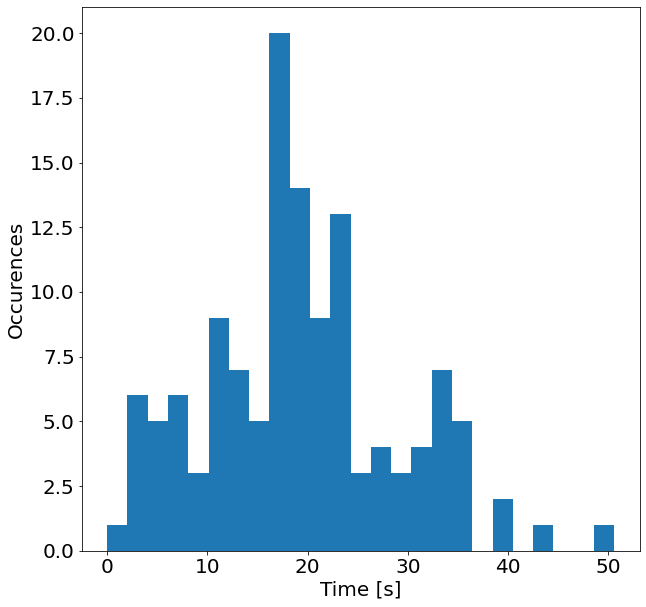

In [59]:
maxenddf = df_128lambdas.groupby('uuid')[["endTime"]].max().reset_index()
maxenddf["endTime"] = maxenddf["endTime"] / 1000


fig, ax = pyplot.subplots(figsize=(10,10))
#pyplot.title("Ending time of each lambda relative to the first one")
pyplot.xlabel("Time [s]", size=20)
pyplot.ylabel("Occurences", size=20)
pyplot.tick_params(labelsize=20)

pyplot.hist(maxenddf["endTime"]-maxenddf["endTime"].min(), bins=25)

fig.savefig('relativeend_pps.png',
            format='png',
            dpi=400,
            bbox_inches='tight')